In [1]:
# !pip install grad-cam

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
import warnings

from pathlib import Path

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict


import models
import utils
import sys
import cv2
from datasetsV2 import get_transform_to_eval, get_transform_to_eval_NO_SRM, get_transform_to_eval_Sobel
from torchvision.transforms import ToPILImage

from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,  log_loss
import math

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [4]:
def preprocess_image_transform(image_path, transform):
    image = Image.open(image_path).convert('RGB').resize((224, 224))
    image = np.array(image)
    augmented = transform(image=image)
    return augmented['image'].squeeze(0)

In [5]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
result_dict = {}
prob_dict = {}

In [7]:
def detect_deepfake(imgs_paths, video_name, count_thresh, n_images, transform, model):
    count_fake = 0
    count_real = 0
    # for img in imgs_paths:
    if n_images <= len(imgs_paths):
        imgs_paths = random.sample(imgs_paths, n_images)

    input_tensor = [preprocess_image_transform(x, transform) for x in imgs_paths]
    input_tensor = torch.stack((input_tensor))

    # print(input_tensor.shape)
    # for img in input_tensor:
    img = input_tensor.to(device)
    results = model(img)
    pred = torch.sigmoid(results)
    # print(pred)
    pred = pred.to('cpu')
    for result in pred:
        detected = "FAKE" if result.item() > 0.5 else "REAL"
        if detected == "FAKE":
            count_fake += 1
        else:
            count_real += 1


    if count_fake > count_real:
        result_dict[video_name] = 1
        # print("FAKE")
    else:
        result_dict[video_name] = 0
        # print("REAL")
    
    # Calculando a média das predições e armazenando no dicionário
    pred_mean = np.mean(pred.detach().numpy().tolist())
    prob_dict[video_name] = pred_mean

In [8]:
def make_predictions(logs_path):
    backbone = ''
    args = open(os.path.join(logs_path, 'args.txt'),'r')
    for txt in args:
        if "model" in txt:
            print(txt)
            backbone = txt.split(' ')[-1][:-1]

    model = create_model(
    backbone,
    pretrained=True,
    num_classes=1
)
    model_path = os.path.join(logs_path, 'model_best.pth')
    checkpoint = torch.load(model_path, map_location='cpu')
    utils.load_checkpoint(model, checkpoint['model'])
    model.eval()

    transform = get_transform_to_eval_NO_SRM(224)
    model.to(device)

    source_dir = '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces'
    labels_dir = '/home/eferreira/master/storage/dfdc/dfdc/test/labels.csv'


    for video in tqdm(os.listdir(source_dir)):
    # print(video)
        parent_name = os.path.join(source_dir, video)
        # print(parent_name)
        imgs = os.listdir(parent_name)
        imgs = [os.path.join(parent_name, x) for x in imgs]
        # print(imgs)
        detect_deepfake(imgs, video, 18, 30,transform, model)
    
    save_dir = logs_path
    
    results_json_path = os.path.join(save_dir, 'results_dfdc.json')
    print("saving to: ", results_json_path)
    with open(results_json_path, "w") as outfile: 
        json.dump(result_dict, outfile)

    results_prob_json_path = os.path.join(save_dir, 'results_prob_dfdc.json')
    print("saving to: ", results_prob_json_path)
    with open(results_prob_json_path, "w") as outfile: 
        json.dump(prob_dict, outfile)
    
    df = pd.read_csv(labels_dir)
    # df.columns = ['label', 'filename']
    df['id'] = df['filename'].apply(lambda x: x[:-4])
    df['filename'] = df['filename'].map(lambda x: x.split("/")[-1].split('.')[0])
    df = df.sort_values(by='filename')
    df_filtered = df[df['filename'].isin(result_dict.keys())]
    df_filtered['prediction'] = df_filtered['filename'].map(result_dict)    
    df_filtered['prediction_prob'] = df_filtered['filename'].map(prob_dict) 

    # Calculando as métricas

    y_true = df_filtered['label']
    y_pred = df_filtered['prediction']
    y_pred_prob = df_filtered['prediction_prob']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_prob)

    # Exibindo as métricas
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Log Loss: {logloss:.2f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Logloss'],
    'Value': [accuracy, precision, recall, f1, roc_auc, logloss]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_path = os.path.join(save_dir, 'metrics_dfdc.csv')
    metrics_df.to_csv(os.path.join(save_dir, 'metrics_dfdc.csv'), index=False)

        # Plotando e salvando o gráfico da curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_dir, 'roc_curve_dfdc.png'))
    plt.show()


In [9]:
# log_path = ['/home/eferreira/master/cross-vit/CrossViT/old_logs/7', '/home/eferreira/master/cross-vit/CrossViT/old_logs/8', '/home/eferreira/master/cross-vit/CrossViT/old_logs/9', '/home/eferreira/master/cross-vit/CrossViT/old_logs/10', '/home/eferreira/master/cross-vit/CrossViT/old_logs/11']
log_path = ['old_logs/28_sobel_l_branch']
# log_path = [f'/home/eferreira/master/cross-vit/CrossViT/old_logs/{x}' for x in range(0, 7)]
log_path

['old_logs/28_sobel_l_branch']

model: crossvit_18_dagger_224_sobel

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmp1ysqa3c4 ...


  0%|          | 0/4964 [00:00<?, ?it/s]

saving to:  old_logs/28_sobel_l_branch/results_dfdc.json
saving to:  old_logs/28_sobel_l_branch/results_prob_dfdc.json
Accuracy: 0.68
Precision: 0.63
Recall: 0.84
F1 Score: 0.72
Log Loss: 0.75


/tmp/ipykernel_952882/1686234154.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['prediction'] = df_filtered['filename'].map(result_dict)
/tmp/ipykernel_952882/1686234154.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['prediction_prob'] = df_filtered['filename'].map(prob_dict)


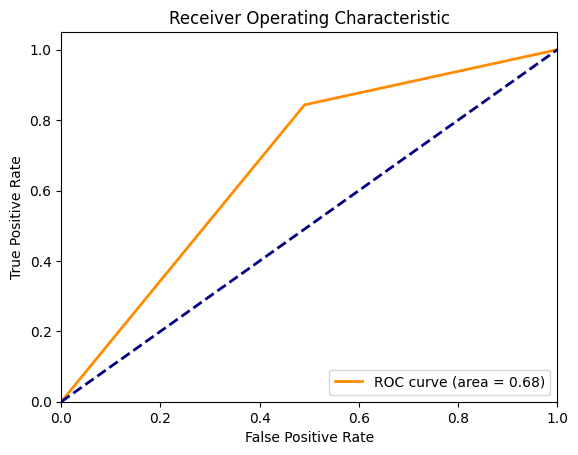

In [10]:
for path in log_path:
    make_predictions(path)